In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

def feature_engineering(df):

    df_eng = df.copy()

    df_eng = df_eng.drop(columns=['Id', 'AvgTime'])

    df_eng['VIP'] = df_eng['VIP'].fillna(False).astype(int)
    df_eng['Age'] = df_eng['Age'].fillna(df_eng['Age'].median())
    df_eng[['Food', 'Drinks']] = df_eng[['Food', 'Drinks']].fillna(0)

    df_eng['TotalSpent'] = df_eng['Food'] + df_eng['Drinks']
    df_eng['Has_Spent'] = (df_eng['TotalSpent'] > 0).astype(int)
    df_eng['FoodShare'] = df_eng['Food'] / (df_eng['TotalSpent'] + 0.01)
    
    # --- Vinyl: imputación por PreferedAlbum ---
    # 1) Calcula la moda de Vinyl por álbum usando solo los NO-NaN
    vinyl_mode_by_album = (
        df_eng.dropna(subset=['Vinyl'])
            .groupby('PreferedAlbum')['Vinyl']
            .agg(lambda x: x.mode().iloc[0])
    )

    # 2) Rellena los NaN de Vinyl con la moda del álbum correspondiente
    mask = df_eng['Vinyl'].isna()
    df_eng.loc[mask, 'Vinyl'] = df_eng.loc[mask, 'PreferedAlbum'].map(vinyl_mode_by_album)

    # 3) Si aún quedan NaN (álbum no visto o sin moda), rellena con la moda global
    global_mode_vinyl = df_eng['Vinyl'].mode(dropna=True)[0]
    df_eng['Vinyl'] = df_eng['Vinyl'].fillna(global_mode_vinyl).astype(int)

    modePreferedAlbum = df_eng['PreferedAlbum'].mode()[0]
    df_eng['PreferedAlbum'] = df_eng['PreferedAlbum'].fillna(modePreferedAlbum)
    
    modeConcert = df_eng['Concert'].mode()[0]
    df_eng['Concert'] = df_eng['Concert'].fillna(modeConcert)

    #Tickets
    # Tickets
    ticket = (
        df_eng['TicketInfo']
        .fillna('Unknown/Unknown/Unknown')
        .str.split('/', expand=True)
    )

    df_eng['Ticket_Zone'] = ticket[0]
    df_eng['Ticket_Number'] = pd.to_numeric(ticket[1], errors='coerce')
    df_eng['Ticket_Type'] = ticket[2]
    # Ticket_Number: crea flag + imputa
    df_eng['Ticket_Number_Missing'] = df_eng['Ticket_Number'].isna().astype(int)
    df_eng['Ticket_Number'] = df_eng['Ticket_Number'].fillna(df_eng['Ticket_Number'].median())
    df_eng = df_eng.drop(columns=['TicketInfo'])

    scale_cols = ['Age', 'Food', 'Drinks', 'TotalSpent', 'Ticket_Number']

    for col in scale_cols:
        mean = df_eng[col].mean()
        std = df_eng[col].std()
        df_eng[col] = (df_eng[col] - mean) / std


    return df_eng

train_df = feature_engineering(train)
test_df = feature_engineering(test)

C:\Users\Admin\AppData\Local\Temp\ipykernel_7004\1262061679.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_eng['VIP'] = df_eng['VIP'].fillna(False).astype(int)
C:\Users\Admin\AppData\Local\Temp\ipykernel_7004\1262061679.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_eng['Vinyl'] = df_eng['Vinyl'].fillna(global_mode_vinyl).astype(int)
C:\Users\Admin\AppData\Local\Temp\ipykernel_7004\1262061679.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.in

In [4]:
train_df.info()
y = train_df['FreePass']
train_df = train_df.drop(columns=['FreePass'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10116 entries, 0 to 10115
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PreferedAlbum          10116 non-null  object 
 1   Vinyl                  10116 non-null  int64  
 2   Opinion                8613 non-null   object 
 3   Concert                10116 non-null  object 
 4   Age                    10116 non-null  float64
 5   VIP                    10116 non-null  int64  
 6   Food                   10116 non-null  float64
 7   Drinks                 10116 non-null  float64
 8   FreePass               10116 non-null  bool   
 9   TotalSpent             10116 non-null  float64
 10  Has_Spent              10116 non-null  int64  
 11  FoodShare              10116 non-null  float64
 12  Ticket_Zone            10116 non-null  object 
 13  Ticket_Number          10116 non-null  float64
 14  Ticket_Type            10116 non-null  object 
 15  Ti

In [5]:
num_cols = ['Age', 'Food', 'Drinks', 'TotalSpent', 'Ticket_Number', 'FoodShare']
bool_cols = ['VIP', 'Has_Spent', 'Vinyl']
cat_cols = ['PreferedAlbum', 'Concert', 'Ticket_Zone', 'Ticket_Type']

for df in [train_df, test_df]:
    df['Opinion'] = (
        df['Opinion']
        .fillna('')
        .astype(str)
        .str.lower()
        .str.replace(r'[^a-z0-9\s]', ' ', regex=True)
        .str.replace(r'\s+', ' ', regex=True)
        .str.strip()
    )


In [6]:
text_train = train_df['Opinion']
text_test  = test_df['Opinion']

train_df_no_text = train_df.drop(columns=['Opinion'])
test_df_no_text  = test_df.drop(columns=['Opinion'])

train_X = pd.get_dummies(train_df_no_text, columns=cat_cols, dummy_na=True)
test_X  = pd.get_dummies(test_df_no_text,  columns=cat_cols, dummy_na=True)

train_X, test_X = train_X.align(test_X, join='left', axis=1, fill_value=0)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# vectorizer = TfidfVectorizer(
#     min_df=2,
#     max_df=0.9,
#     ngram_range=(1,2),
#     max_features=30000
# )

vectorizer = CountVectorizer(
    min_df=2,
    stop_words='english',
    strip_accents='unicode'
)

Xtr_text = vectorizer.fit_transform(text_train)
Xte_text = vectorizer.transform(text_test)

In [ ]:
train_X_notxt = train_X.drop(columns=['Opinion'], errors='ignore')
test_X_notxt  = test_X.drop(columns=['Opinion'], errors='ignore')

In [9]:
from scipy.sparse import hstack, csr_matrix

Xtr_other = csr_matrix(train_X_notxt.to_numpy(dtype=float))
Xte_other = csr_matrix(test_X_notxt.to_numpy(dtype=float))


Xtr_final = hstack([Xtr_other, Xtr_text])
Xte_final = hstack([Xte_other, Xte_text])


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


X_train_notxt, X_val_notxt, y_train, y_val = train_test_split(
    train_X_notxt,
    y,
    test_size=0.30,
    random_state=42,
)

X_train, X_val, y_train, y_val = train_test_split(
    Xtr_final,
    y,
    test_size=0.30,
    random_state=42,
)   

from sklearn.linear_model import LogisticRegression

clfLog = LogisticRegression(
    max_iter=3000,
    C=2,
    solver='liblinear',
)

clfSLV = LinearSVC(
    max_iter=3000,
    C=1,
)

# clfRFold = RandomForestClassifier(
#     n_estimators=500,
#     max_depth=10,
#     random_state=42,
#     class_weight='balanced'
# )

clfRF = RandomForestClassifier(
    n_estimators=800,
    min_samples_split=20,
    min_samples_leaf=5,
    max_features=0.3,
    max_depth=12,
    random_state=42,
    class_weight=None,
    bootstrap=True
)
# Best params: {'n_estimators': 800, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 0.3, 
#               'max_depth': 12, 'class_weight': None, 'bootstrap': True}

clfDT = DecisionTreeClassifier(
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)


clfLog.fit(X_train, y_train)
clfSLV.fit(X_train, y_train)
clfRF.fit(X_train_notxt, y_train)
clfDT.fit(X_train, y_train)


from sklearn.metrics import accuracy_score, classification_report

y_pred_Log = clfLog.predict(X_val)
y_pred_SLV = clfSLV.predict(X_val)
y_pred_RF  = clfRF.predict(X_val_notxt)
y_pred_DT  = clfDT.predict(X_val)

print("Accuracy Log (YES Opinion):", accuracy_score(y_val, y_pred_Log))
# print(classification_report(y_val, y_pred_Log))

print("Accuracy SLV (YES Opinion):", accuracy_score(y_val, y_pred_SLV))
# print(classification_report(y_val, y_pred_SLV))

print("Accuracy RF (NO Opinion):", accuracy_score(y_val, y_pred_RF))
# print(classification_report(y_val, y_pred_RF))

print("Accuracy DT (YES Opinion):", accuracy_score(y_val, y_pred_DT))
# print(classification_report(y_val, y_pred_DT))


Accuracy Log (YES Opinion): 0.8079077429983526
Accuracy SLV (YES Opinion): 0.8065897858319605
Accuracy RF (NO Opinion): 0.8187808896210873
Accuracy DT (YES Opinion): 0.8092257001647446


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold


X_train_notxt, X_val_notxt, y_train, y_val = train_test_split(
    train_X_notxt,
    y,
    test_size=0.30,
    random_state=42,
)

clfRF = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

# Define the parameters to try during Randomized Search
param_dist = {
    "n_estimators": [300, 500, 800, 1200],
    "max_depth": [None, 8, 12, 16, 20],
    "min_samples_leaf": [1, 2, 5, 10, 20],
    "min_samples_split": [2, 5, 10, 20],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.8],
    "bootstrap": [True],                 # RF típico
    "class_weight": [None, "balanced"]   # a veces ayuda
}

CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Divides the data into 5 folds, preserving class distribution, shuffling for randomness.
# Folding means that in each iteration, 4 folds are used for training and 1 for validation.


# It checks 50 different combinations of the above parameters
# The Kfold divides the data into 5 parts, training on 4 and validating on 1 each time. 
# For each combination of parameters it finds 5 values of the accuracy and then averages them to get a final score.
search = RandomizedSearchCV(
    estimator=clfRF,
    param_distributions=param_dist,
    n_iter=50, # number of different combinations to try
    scoring='accuracy',
    cv = CV,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_notxt, y_train)

print("Best CV accuracy:", search.best_score_)
print("Best params:", search.best_params_)
best_rf = search.best_estimator_

results = pd.DataFrame(search.cv_results_)
cols = ["mean_test_score", "std_test_score", "rank_test_score", "params"]
results[cols].sort_values("rank_test_score").head(10)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best CV accuracy: 0.819517341881671
Best params: {'n_estimators': 800, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 0.3, 'max_depth': 12, 'class_weight': None, 'bootstrap': True}


,mean_test_score,std_test_score,rank_test_score,params
41,0.819517,0.006670,1,"{'n_estimators': 800, 'min_samples_split': 20,..."
18,0.819376,0.003109,2,"{'n_estimators': 800, 'min_samples_split': 2, ..."
49,0.818247,0.009022,3,"{'n_estimators': 800, 'min_samples_split': 5, ..."
7,0.817964,0.005290,4,"{'n_estimators': 1200, 'min_samples_split': 2,..."
10,0.817399,0.005441,5,"{'n_estimators': 500, 'min_samples_split': 2, ..."
8,0.817399,0.006588,6,"{'n_estimators': 300, 'min_samples_split': 5, ..."
20,0.817117,0.006912,7,"{'n_estimators': 500, 'min_samples_split': 10,..."
27,0.816976,0.007526,8,"{'n_estimators': 300, 'min_samples_split': 2, ..."
42,0.816835,0.008294,9,"{'n_estimators': 1200, 'min_samples_split': 5,..."
9,0.816834,0.005949,10,"{'n_estimators': 1200, 'min_samples_split': 2,..."


In [46]:
import pandas as pd

best_rf = RandomForestClassifier(
    n_estimators=800,
    min_samples_split=20,
    min_samples_leaf=5,
    max_features=0.3,
    max_depth=12,
    random_state=42,
    class_weight=None,
    bootstrap=True
)

best_rf.fit(X_train_notxt, y_train)

importances = pd.Series(
    best_rf.feature_importances_,
    index=X_train_notxt.columns
).sort_values(ascending=False)

importances.head(15)

TotalSpent                        0.189558
Has_Spent                         0.147587
FoodShare                         0.136720
Vinyl                             0.098502
Food                              0.090943
Drinks                            0.088387
Ticket_Number                     0.066370
Age                               0.036594
PreferedAlbum_Kind of Blue        0.024767
PreferedAlbum_Head Hunters        0.022288
PreferedAlbum_Bright Size Life    0.016326
Ticket_Zone_CB                    0.013792
Ticket_Zone_B                     0.011832
Ticket_Type_XL                    0.011567
Ticket_Type_N                     0.010534
dtype: float64

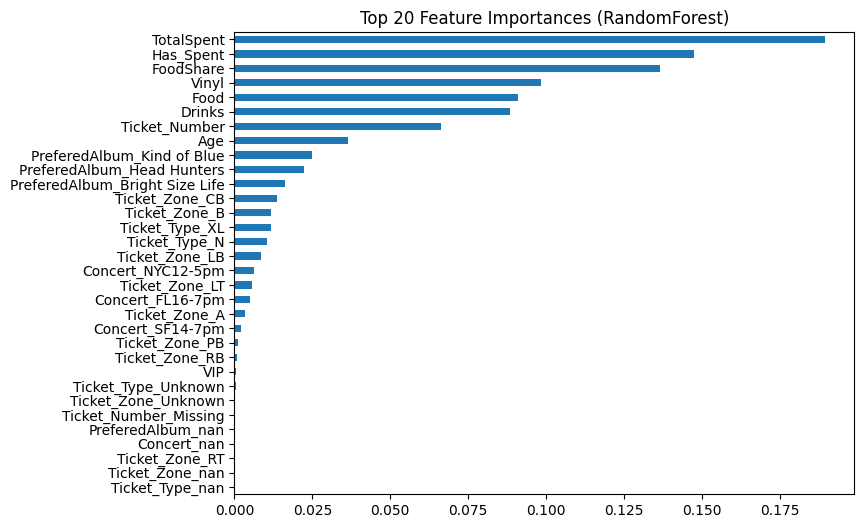

In [52]:
import matplotlib.pyplot as plt

importances.head(100).plot(kind='barh', figsize=(8,6))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (RandomForest)")
plt.show()


In [41]:
clfRF.fit(train_X_notxt, y)
y_test_pred = clfRF.predict(test_X_notxt)
submission = pd.DataFrame({
    'Id': test['Id'],
    'FreePass': y_test_pred
})
submission.to_csv('submission.csv', index=False)